In [51]:
!pip install -U vnstock

In [52]:
from vnstock import *

In [53]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [54]:
data = stock_historical_data(symbol="MSN", start_date="2014-05-31", end_date="2024-05-31", resolution="1D", type="stock", beautify=True, decor=True, source='DNSE')
data

,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2014-06-02,49780,51070,49780,50820,229020,MSN
2014-06-03,50560,51330,50560,51330,184340,MSN
2014-06-04,51590,51590,50560,51070,51080,MSN
2014-06-05,50820,50820,50040,50040,76150,MSN
2014-06-06,50820,50820,49780,50300,22360,MSN
...,...,...,...,...,...,...
2024-05-27,73500,74000,72700,73500,3881500,MSN
2024-05-28,74200,75500,73800,75500,5100400,MSN
2024-05-29,75700,76900,75000,75000,8003700,MSN


In [55]:
data1 = data[['Close','Volume']]
data1

,Close,Volume
Time,,
2014-06-02,50820,229020
2014-06-03,51330,184340
2014-06-04,51070,51080
2014-06-05,50040,76150
2014-06-06,50300,22360
...,...,...
2024-05-27,73500,3881500
2024-05-28,75500,5100400
2024-05-29,75000,8003700


In [56]:
data1['Next_Close'] = data1['Close'].shift(-1)
data1['Class'] = (data1['Next_Close'] > data1['Close']).astype(int)
data1 = data1.dropna()
data1

<ipython-input-56-c88a3b6781b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Next_Close'] = data1['Close'].shift(-1)
<ipython-input-56-c88a3b6781b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Class'] = (data1['Next_Close'] > data1['Close']).astype(int)


,Close,Volume,Next_Close,Class
Time,,,,
2014-06-02,50820,229020,51330.0,1
2014-06-03,51330,184340,51070.0,0
2014-06-04,51070,51080,50040.0,0
2014-06-05,50040,76150,50300.0,1
2014-06-06,50300,22360,50040.0,0
...,...,...,...,...
2024-05-24,73500,7669800,73500.0,0
2024-05-27,73500,3881500,75500.0,1
2024-05-28,75500,5100400,75000.0,0


In [57]:
features = ['Close','Volume']
target = 'Next_Close'

In [58]:
# Cross-validation với 10 subsets và overlap 2%
n_splits = 10
overlap_ratio = 0.02
kf = KFold(n_splits=n_splits, shuffle=False)

In [59]:
df = data1.copy()
accuracies = []
profits = []

# Lưu trữ giá trị thực tế và dự đoán
all_real_prices = []
all_predicted_prices = []

for train_index, test_index in kf.split(df):
    # Bỏ overlap 2% lượng data giữa các subsets
    overlap_size = int(len(train_index) * overlap_ratio)
    train_index = train_index[:-overlap_size] if overlap_size > 0 else train_index

    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(train_data[features], train_data[target])

    test_predictions = model.predict(test_data[features])

    test_data['Predicted_Next_Close'] = test_predictions
    test_data['Class_Predict'] = (test_data['Predicted_Next_Close'] > test_data['Close']).astype(int)
    test_data['Actual_Class'] = (test_data['Next_Close'] > test_data['Close']).astype(int)

    accuracy = accuracy_score(test_data['Actual_Class'], test_data['Class_Predict'])
    accuracies.append(accuracy)

    # Tính toán lợi nhuận
    test_data['Profit'] = 0
    for i in range(len(test_data) - 1):
        if test_data.iloc[i]['Class'] == 1:
            test_data.at[test_data.index[i + 1], 'Profit'] = test_data.iloc[i + 1]['Close'] - test_data.iloc[i]['Close']
        else:
            test_data.at[test_data.index[i + 1], 'Profit'] = test_data.iloc[i]['Close'] - test_data.iloc[i + 1]['Close']

    profits.append(test_data['Profit'].sum())

    # Lưu trữ giá trị thực tế và dự đoán
    all_real_prices.append(test_data['Next_Close'].values)
    all_predicted_prices.append(test_data['Predicted_Next_Close'].values)

<ipython-input-59-0930401aed01>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Next_Close'] = test_predictions
<ipython-input-59-0930401aed01>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Class_Predict'] = (test_data['Predicted_Next_Close'] > test_data['Close']).astype(int)
<ipython-input-59-0930401aed01>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

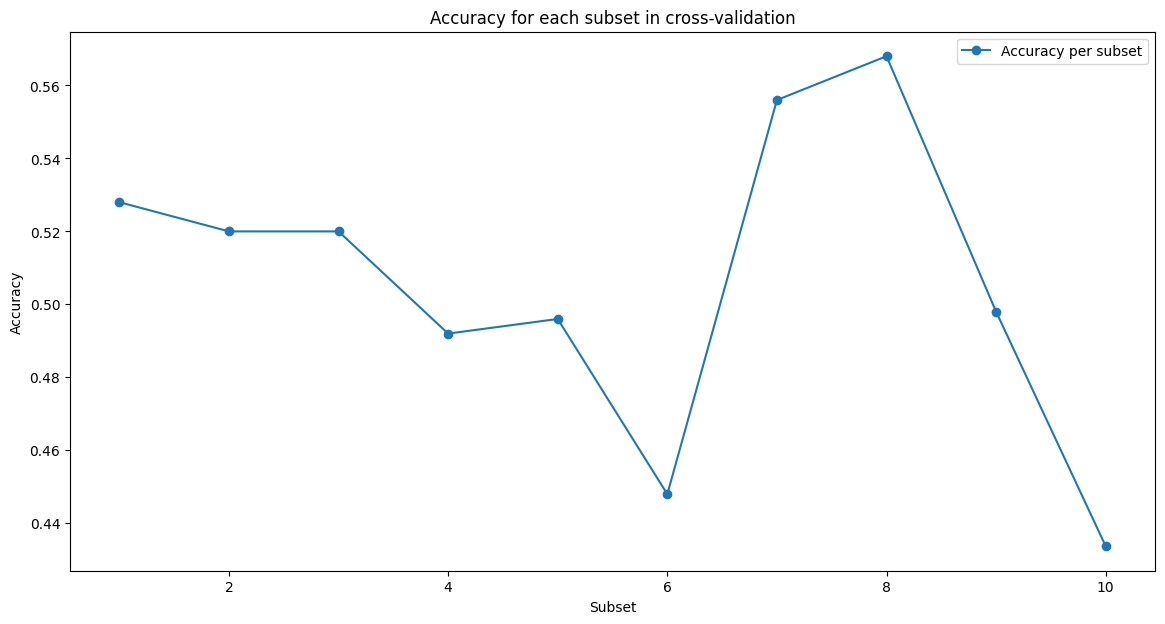

In [60]:
# Biểu diễn tỉ lệ dự đoán đúng với mỗi subset là test data
plt.figure(figsize=(14, 7))
plt.plot(range(1, n_splits + 1), accuracies, marker='o', label='Accuracy per subset')
plt.xlabel('Subset')
plt.ylabel('Accuracy')
plt.title('Accuracy for each subset in cross-validation')
plt.legend()
plt.show()

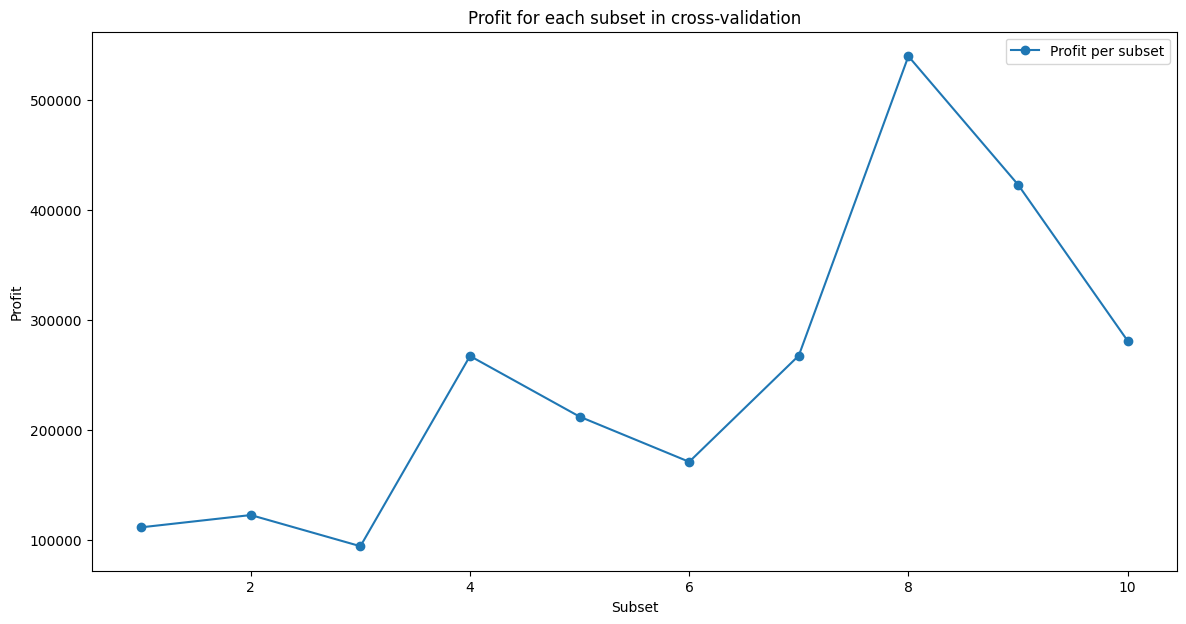

In [61]:
# Biểu diễn lợi nhuận thu được
plt.figure(figsize=(14, 7))
plt.plot(range(1, n_splits + 1), profits, marker='o', label='Profit per subset')
plt.xlabel('Subset')
plt.ylabel('Profit')
plt.title('Profit for each subset in cross-validation')
plt.legend()
plt.show()

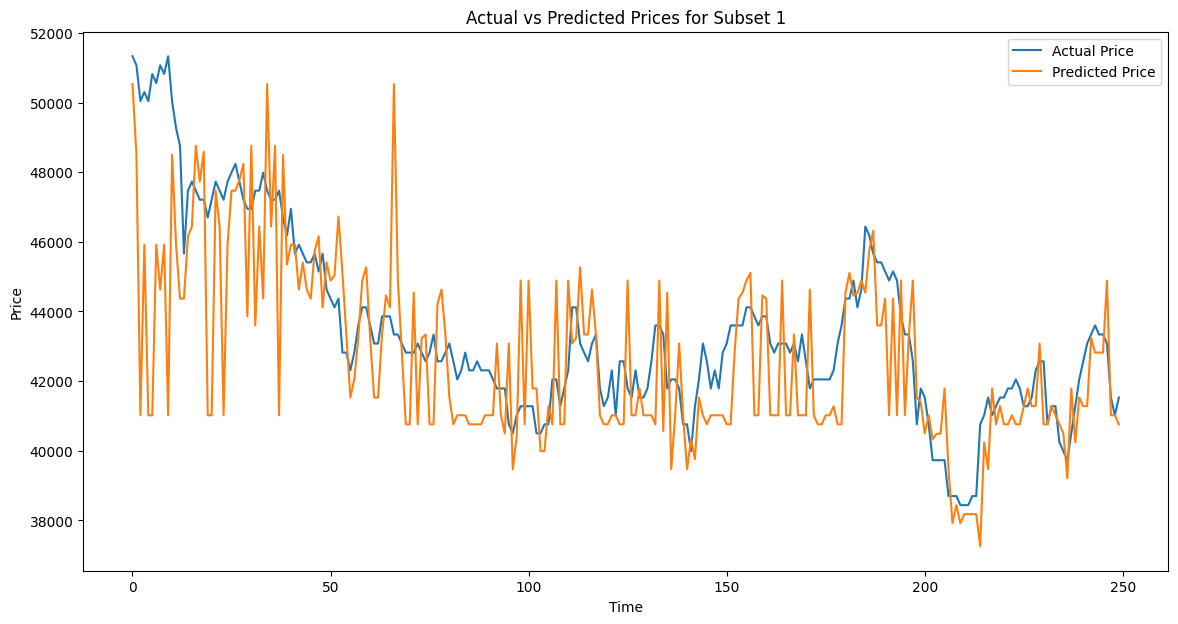

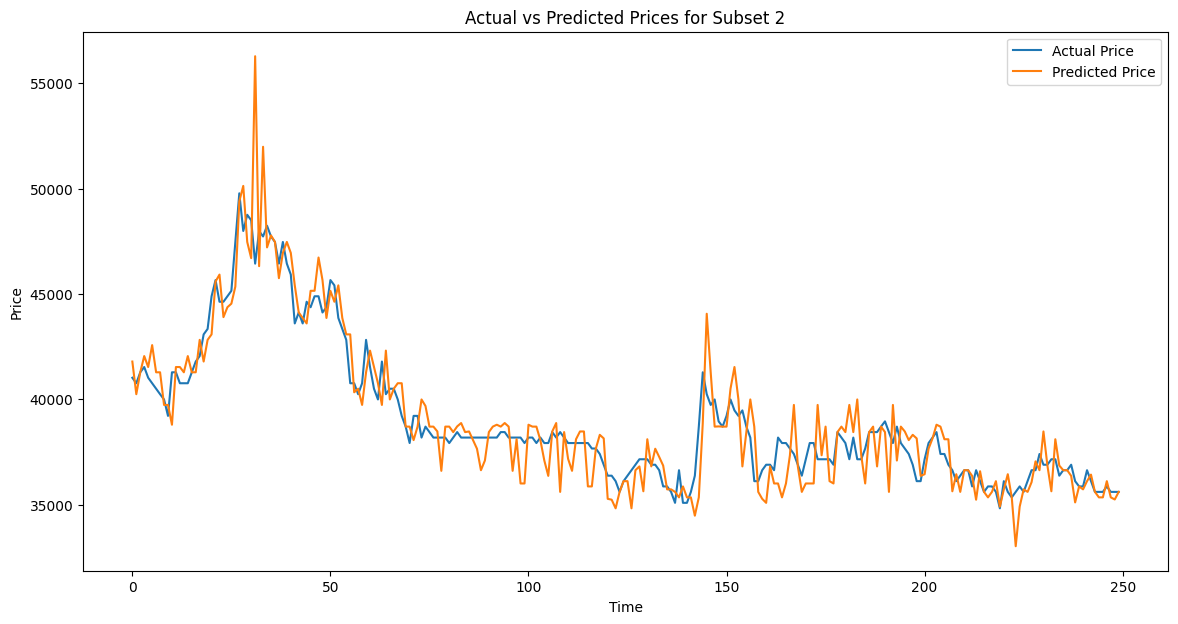

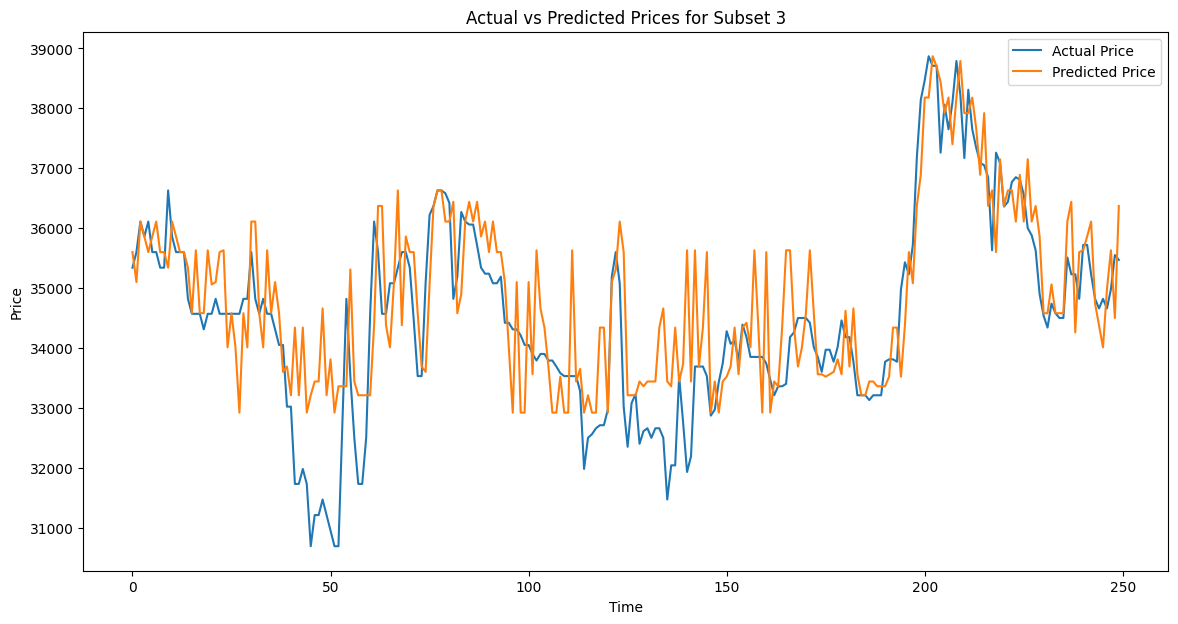

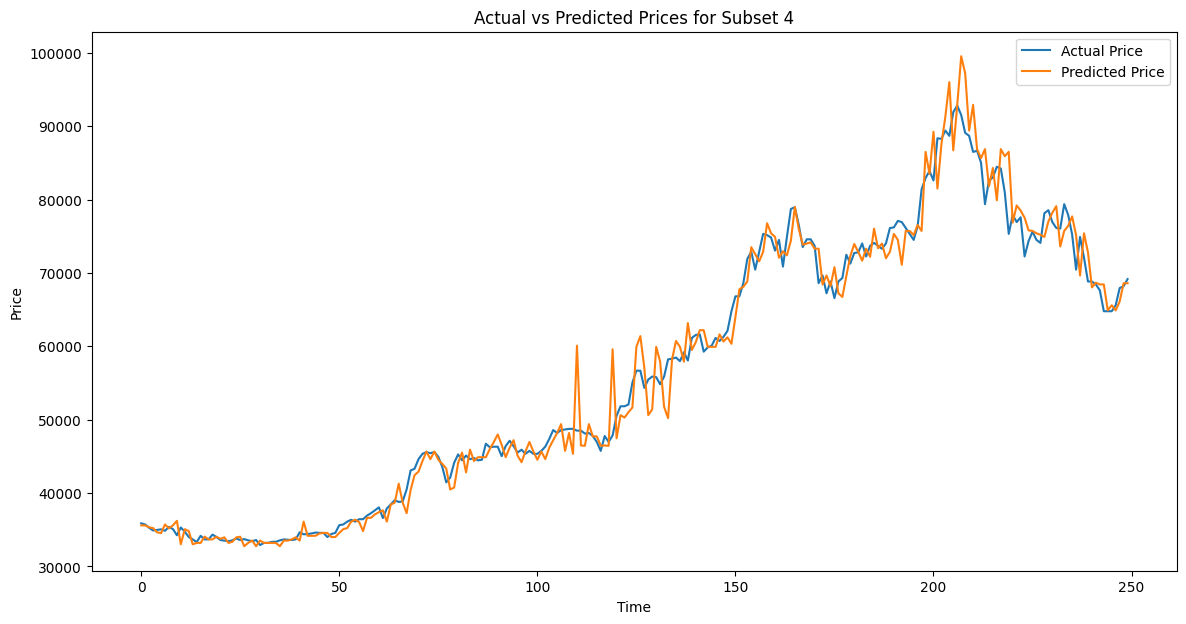

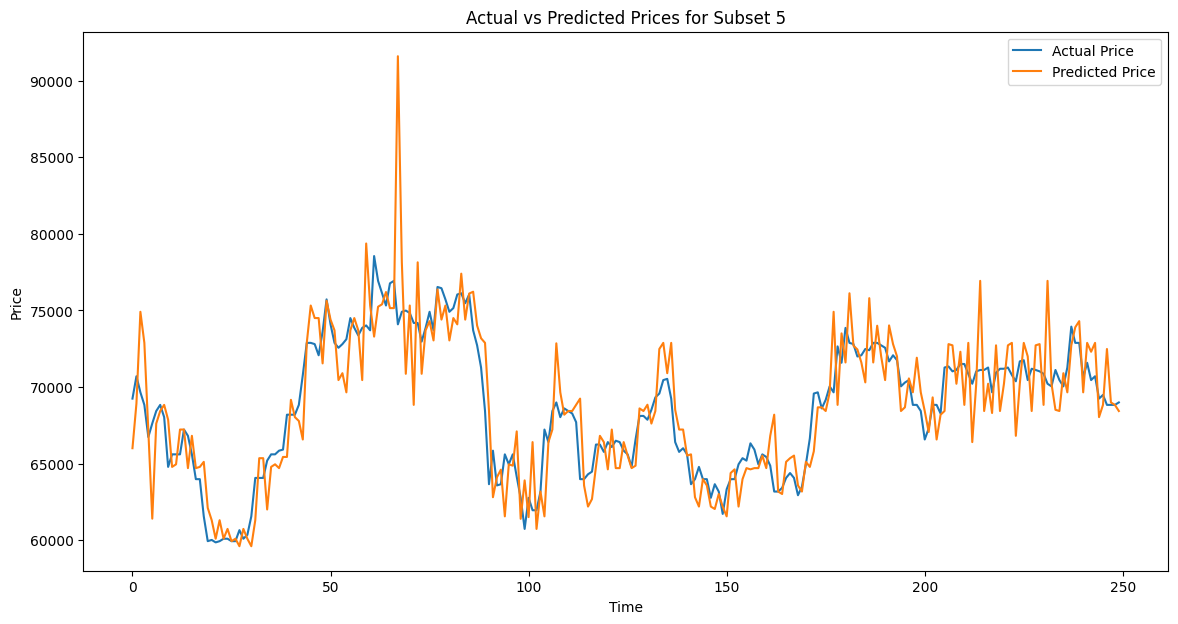

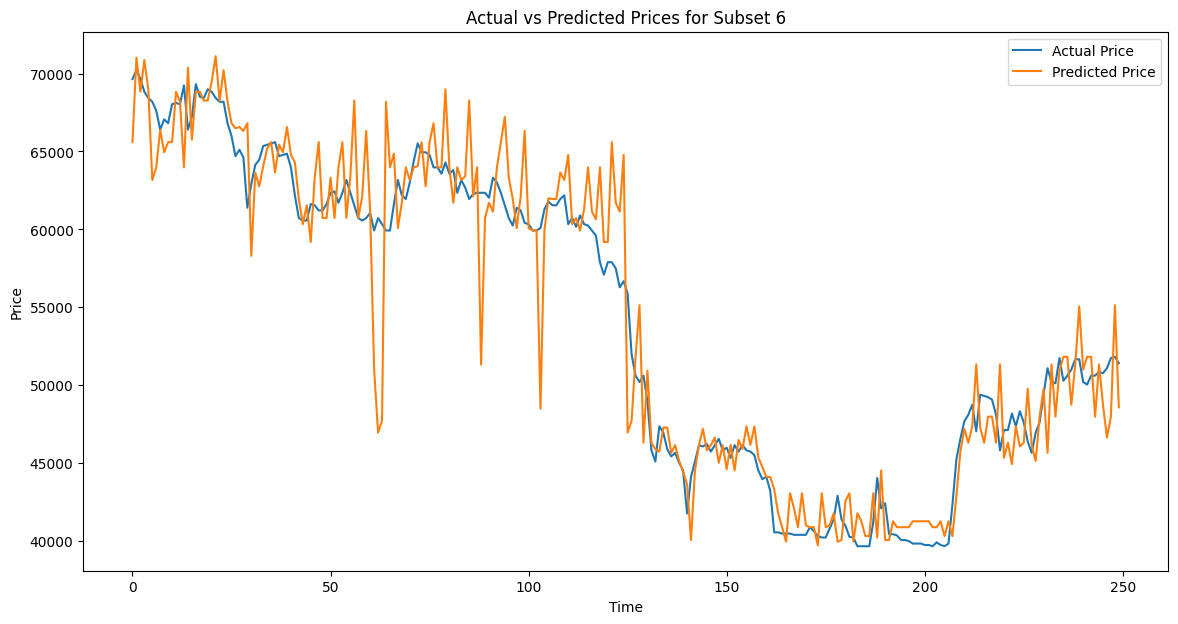

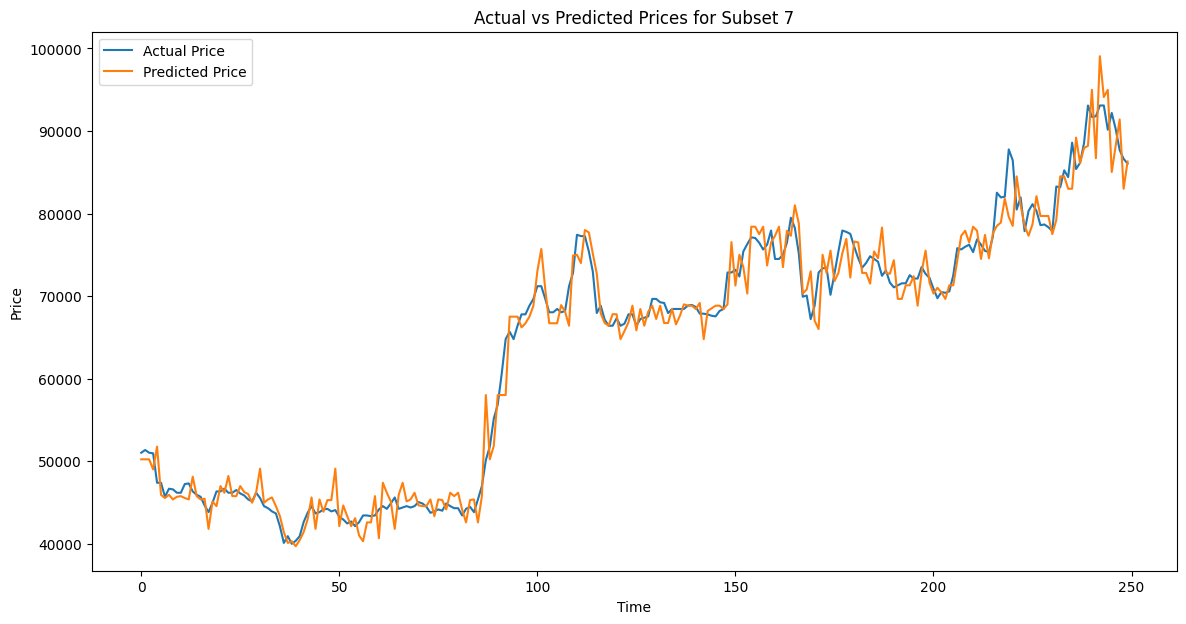

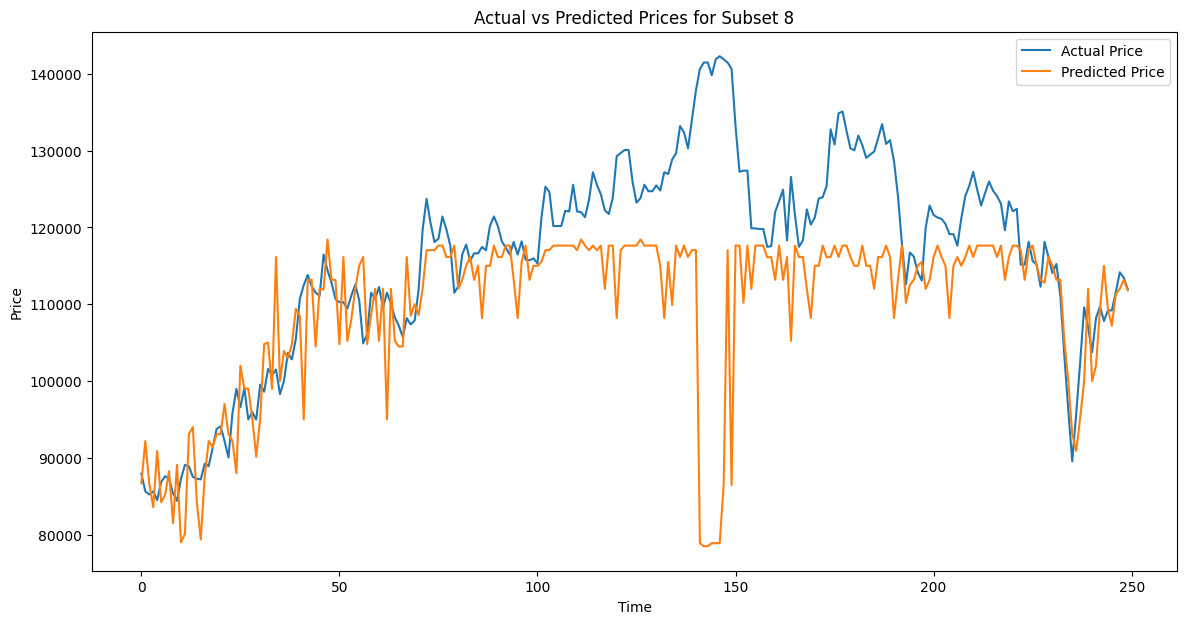

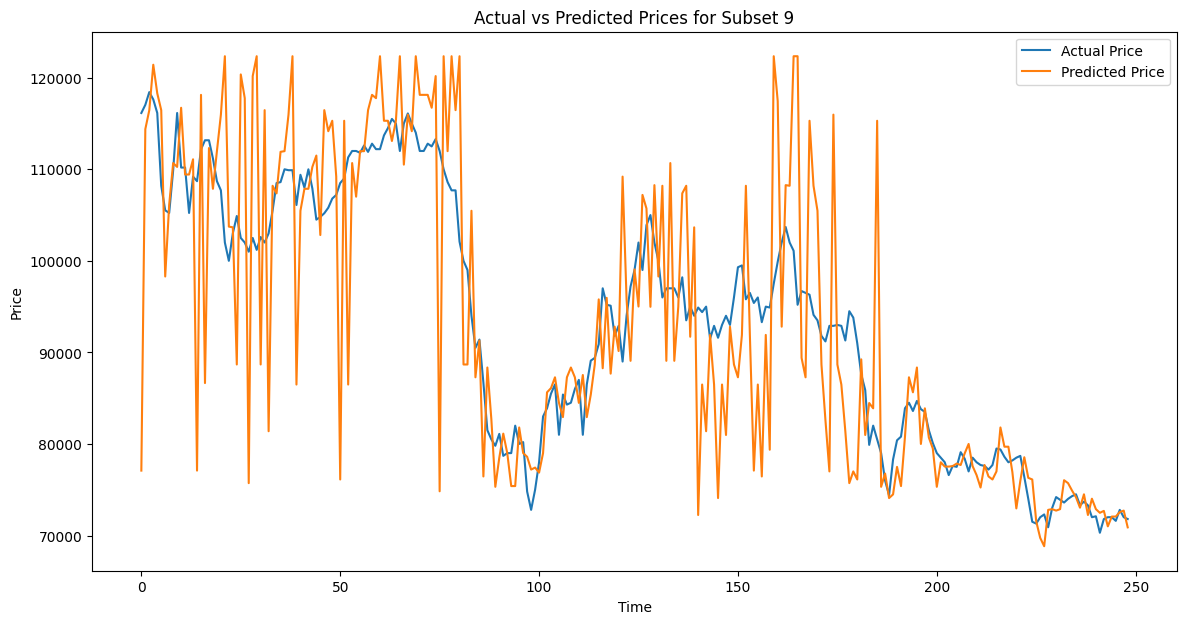

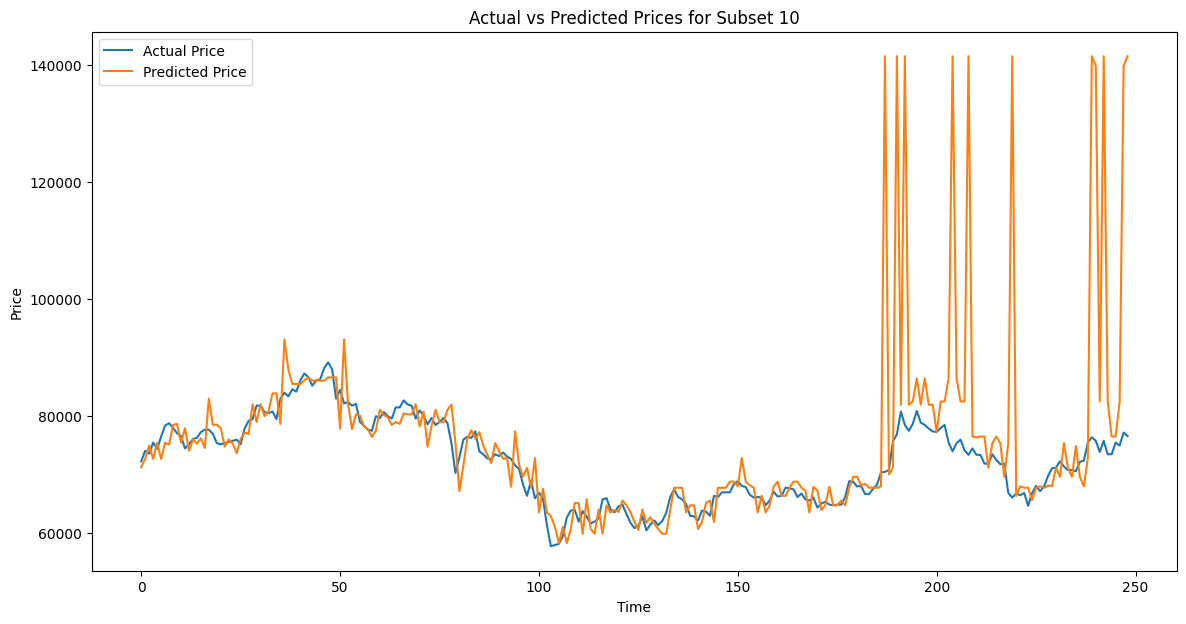

In [62]:
for i in range(n_splits):
    plt.figure(figsize=(14, 7))
    plt.plot(all_real_prices[i], label='Actual Price')
    plt.plot(all_predicted_prices[i], label='Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'Actual vs Predicted Prices for Subset {i + 1}')
    plt.legend()
    plt.show()

In [63]:
df2 = data1.copy()
purge_size = int(len(df2) * 0.02)  # Purge size is 2% of the data
accuracies = []
profits = []
all_real_prices = []
all_predicted_prices = []

for train_index, test_index in kf.split(df2):
    # Bỏ overlap 2% lượng data giữa các subsets (purge)
    train_end = train_index[-1]
    test_start = test_index[0]

    if test_start - train_end <= purge_size:
        test_index = test_index[purge_size:]

    train_data = df2.iloc[train_index]
    test_data = df2.iloc[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(train_data[features], train_data[target])

    test_predictions = model.predict(test_data[features])
    test_probabilities = model.predict_proba(test_data[features])

    test_data['Predicted'] = test_predictions

    accuracy = accuracy_score(test_data[target], test_data['Predicted'])
    accuracies.append(accuracy)

    # Tính toán lợi nhuận
    test_data['Profit'] = 0
    for i in range(len(test_data) - 1):
        if test_data.iloc[i]['Predicted'] == 1:
            test_data.at[test_data.index[i + 1], 'Profit'] = test_data.iloc[i + 1]['Close'] - test_data.iloc[i]['Close']
        else:
            test_data.at[test_data.index[i + 1], 'Profit'] = test_data.iloc[i]['Close'] - test_data.iloc[i + 1]['Close']

    profits.append(test_data['Profit'].sum())

    # Lưu trữ giá trị thực tế và dự đoán
    all_real_prices.append(test_data['Next_Close'].values)
    all_predicted_prices.append(test_data['Predicted'].values)

<ipython-input-63-b2bdf6337552>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted'] = test_predictions
<ipython-input-63-b2bdf6337552>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Profit'] = 0
<ipython-input-63-b2bdf6337552>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

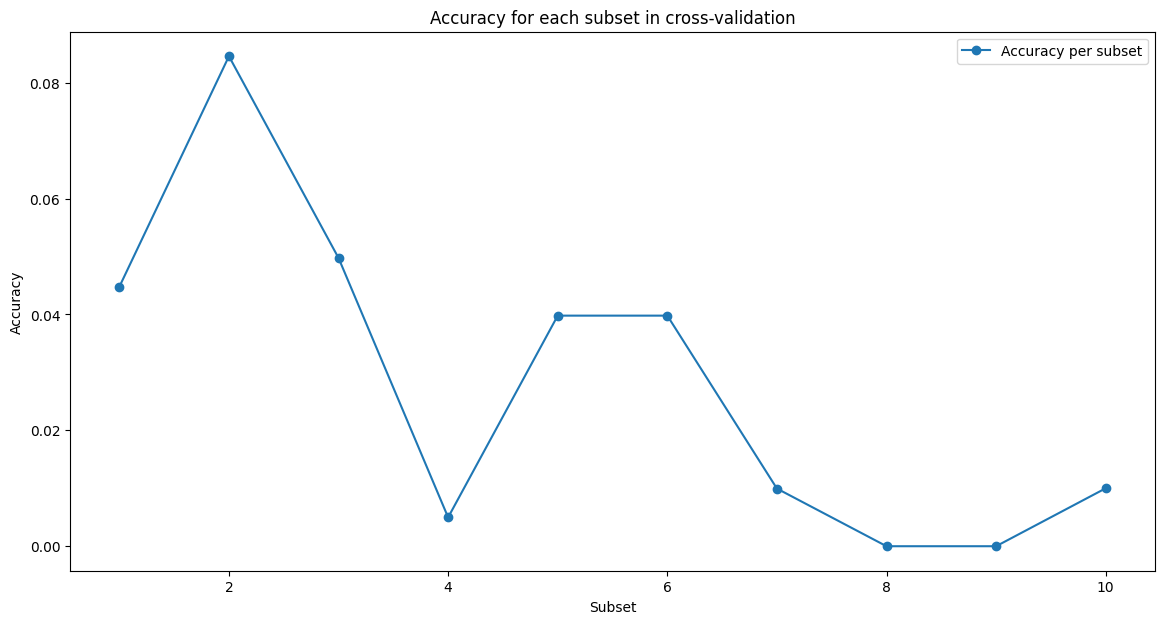

In [64]:
# Biểu diễn tỉ lệ dự đoán đúng với mỗi subset là test data
plt.figure(figsize=(14, 7))
plt.plot(range(1, n_splits + 1), accuracies, marker='o', label='Accuracy per subset')
plt.xlabel('Subset')
plt.ylabel('Accuracy')
plt.title('Accuracy for each subset in cross-validation')
plt.legend()
plt.show()

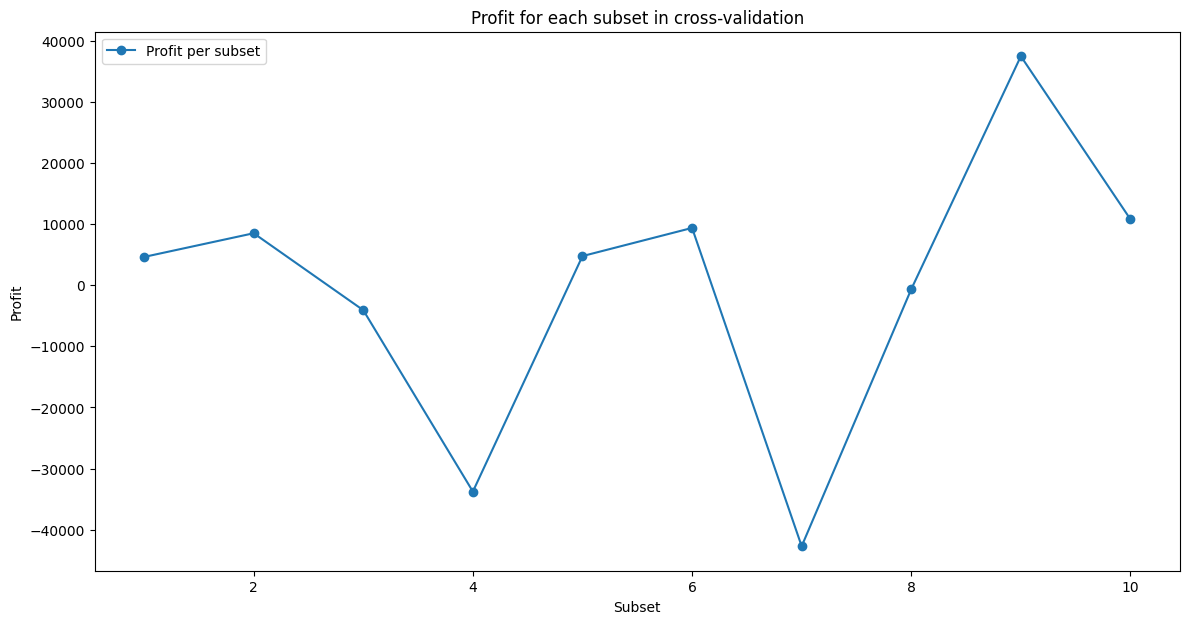

In [65]:
# Biểu diễn lợi nhuận thu được
plt.figure(figsize=(14, 7))
plt.plot(range(1, n_splits + 1), profits, marker='o', label='Profit per subset')
plt.xlabel('Subset')
plt.ylabel('Profit')
plt.title('Profit for each subset in cross-validation')
plt.legend()
plt.show()

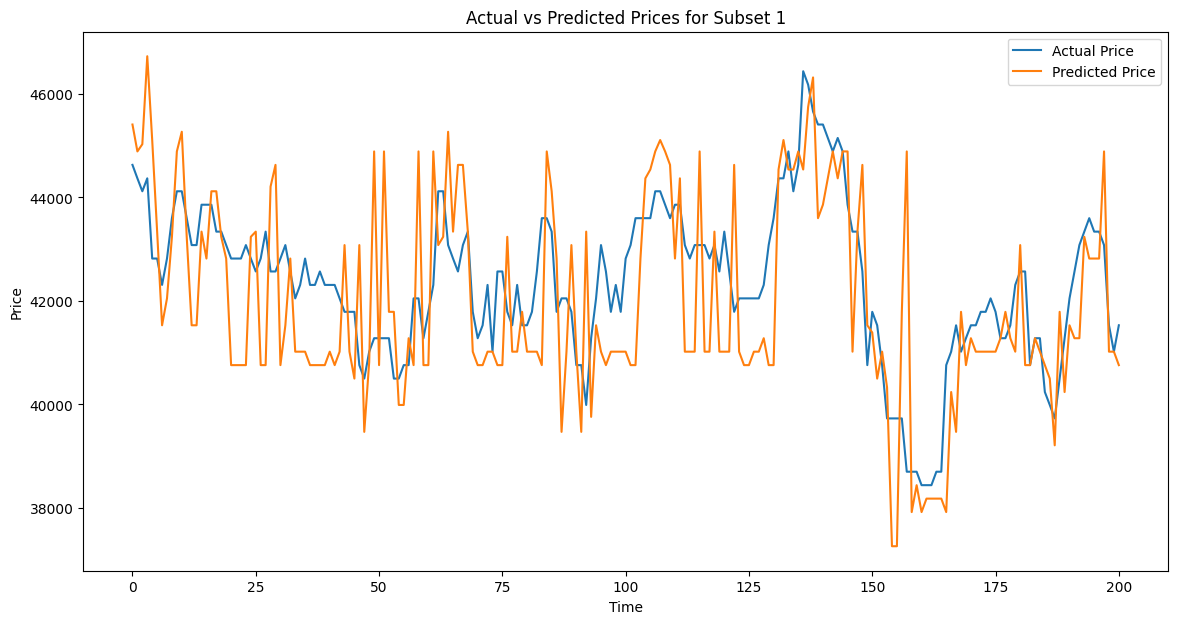

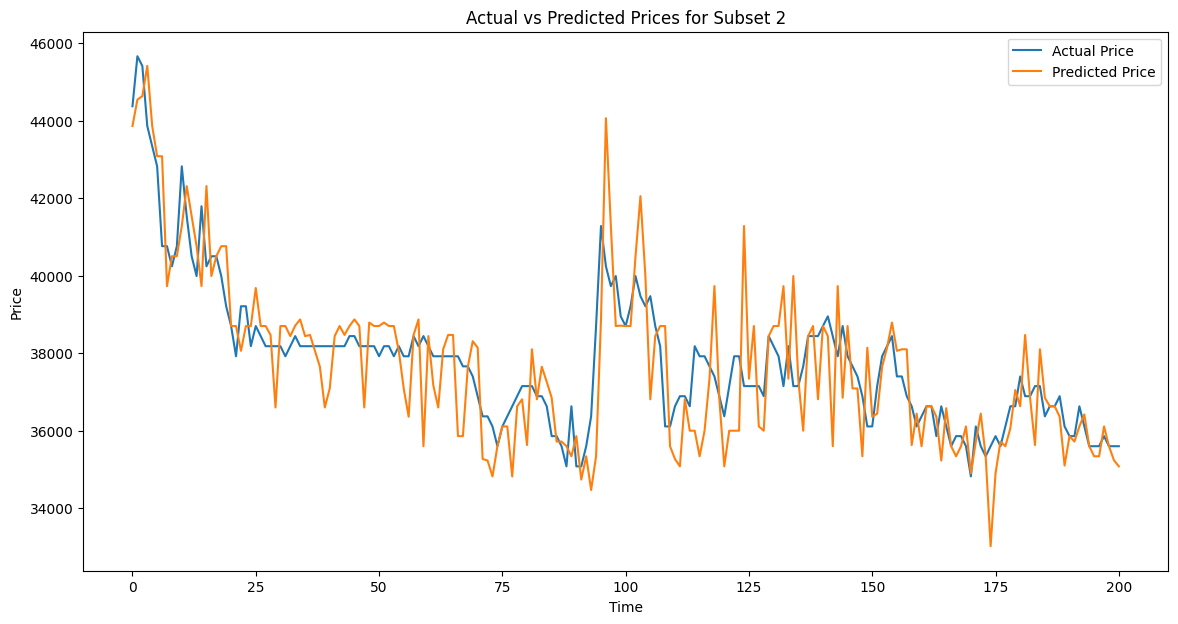

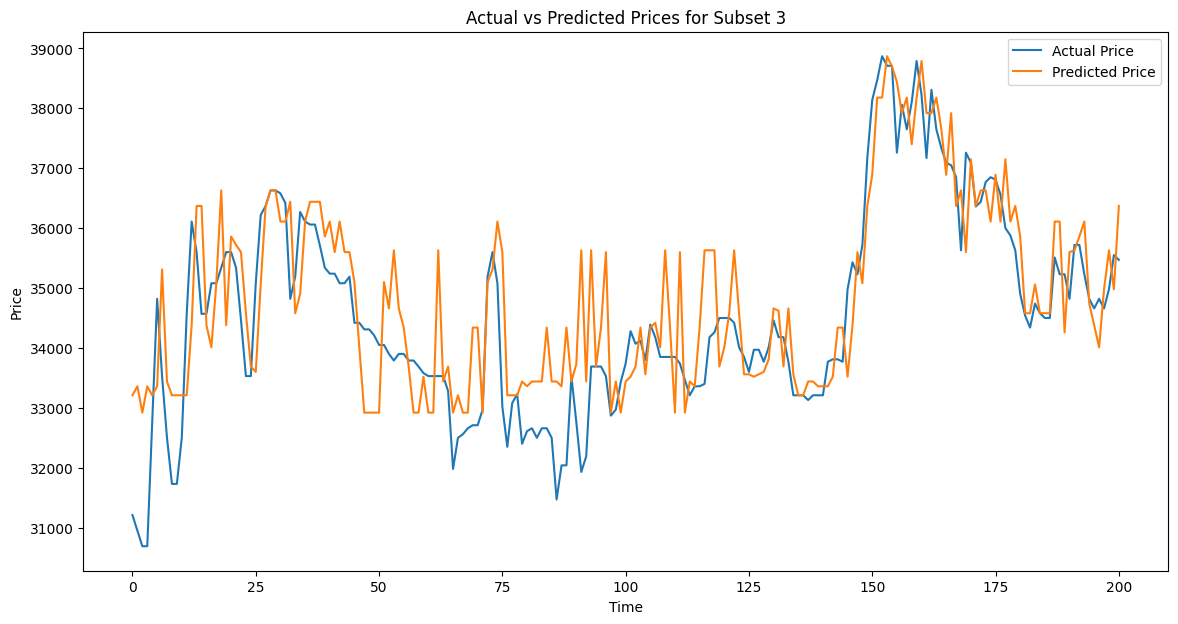

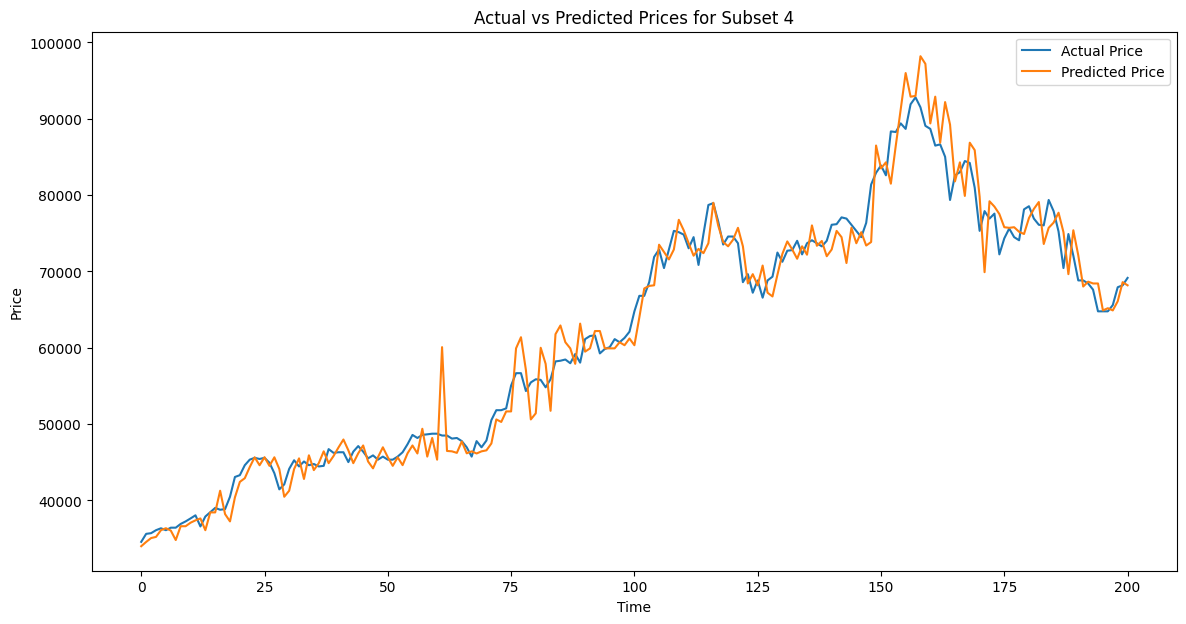

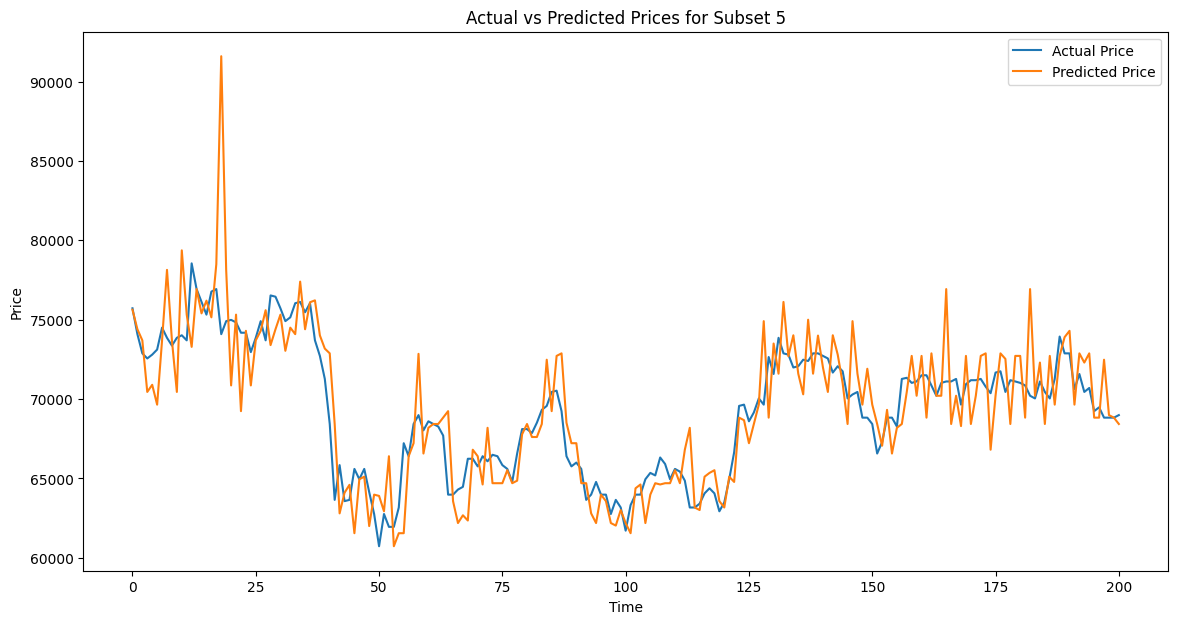

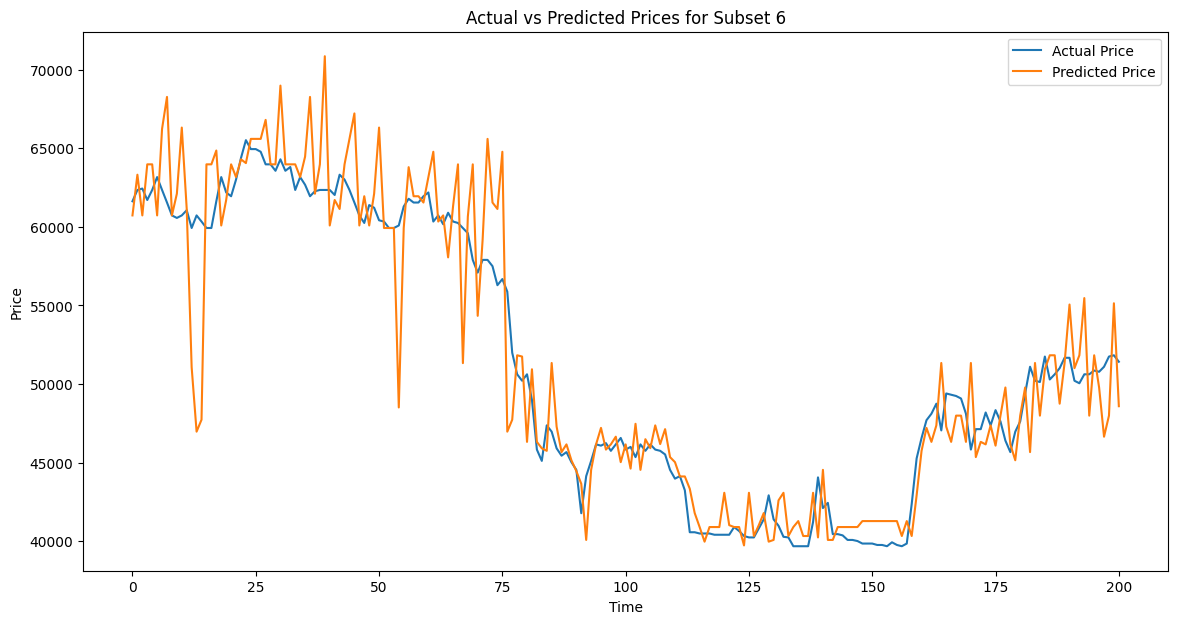

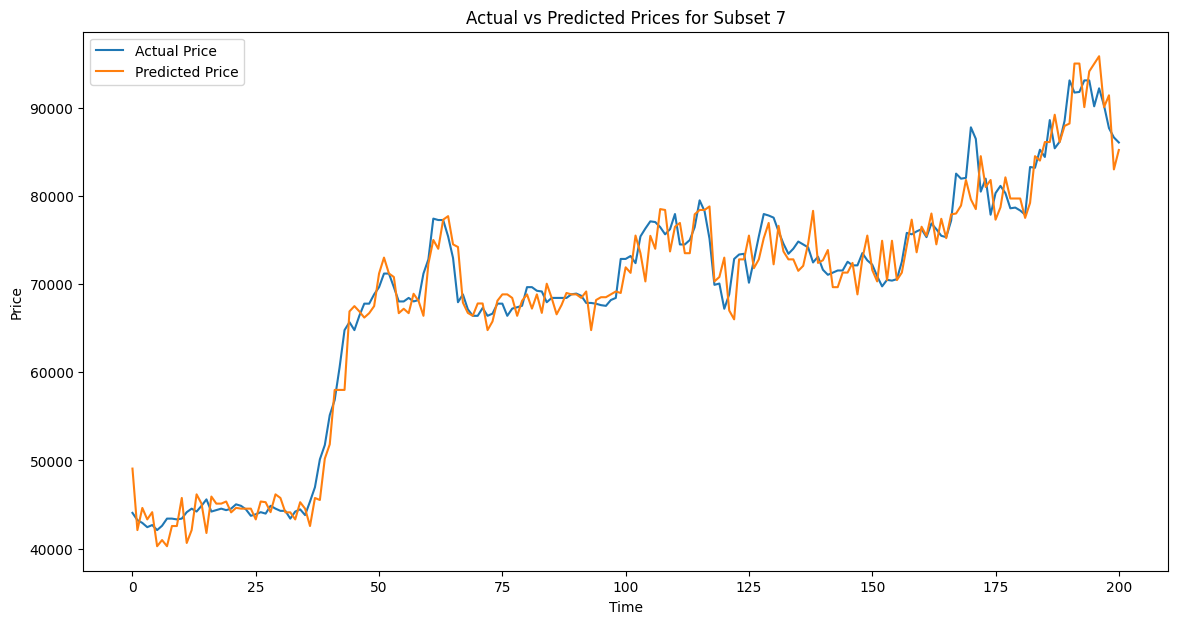

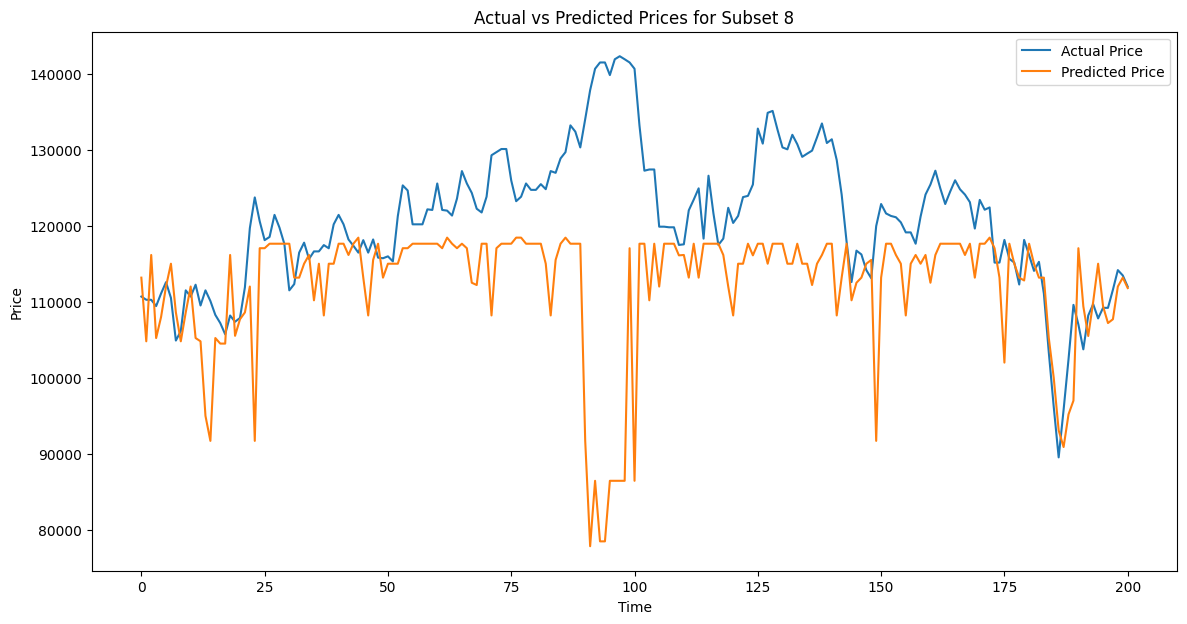

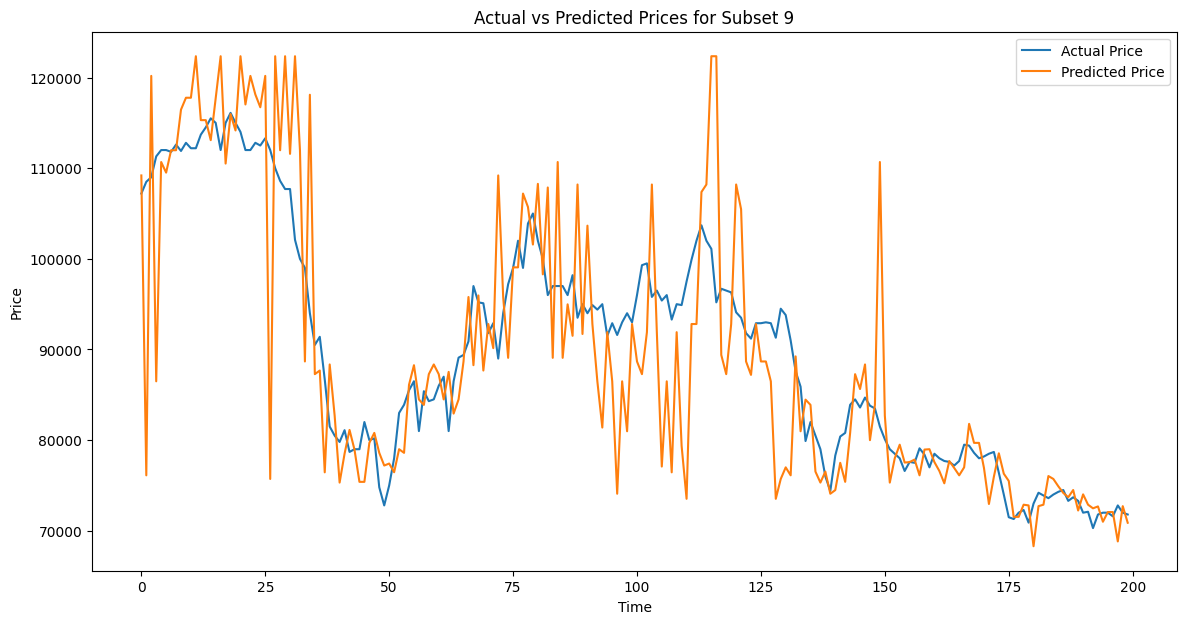

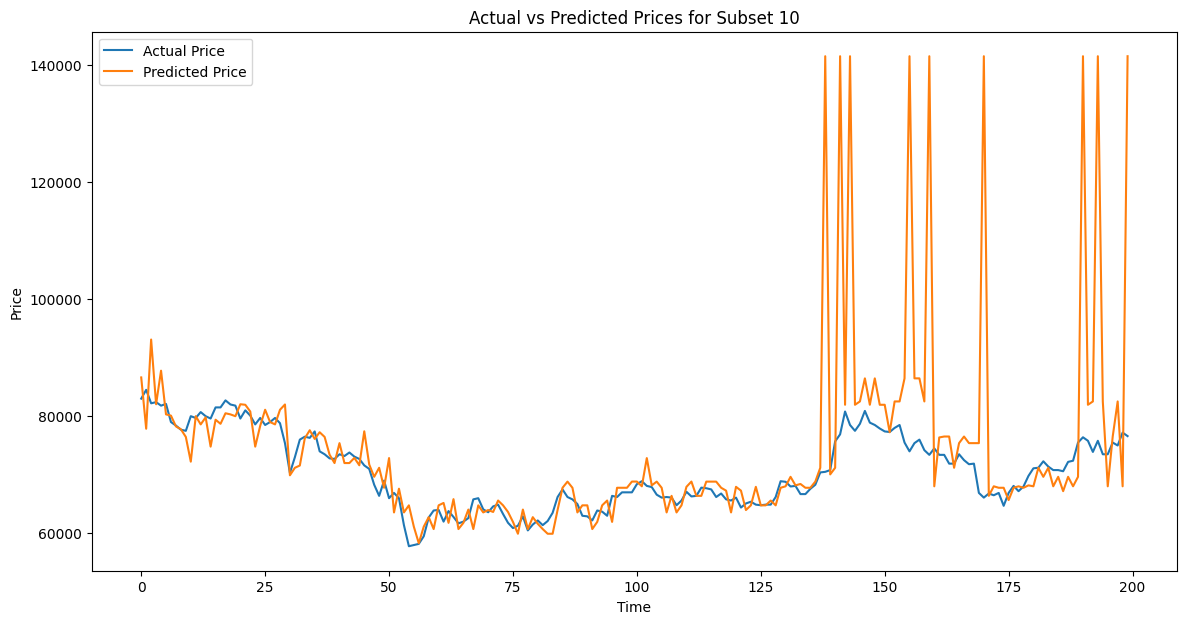

In [66]:
for i in range(n_splits):
    plt.figure(figsize=(14, 7))
    plt.plot(all_real_prices[i], label='Actual Price')
    plt.plot(all_predicted_prices[i], label='Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'Actual vs Predicted Prices for Subset {i + 1}')
    plt.legend()
    plt.show()